In [50]:
!pip install --upgrade opencv-python matplotlib

In [125]:
import tensorflow as tf
import os

In [126]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [127]:
import zipfile
import os

with zipfile.ZipFile('Files.zip', 'r') as zip_ref:
    zip_ref.extractall()  # Extract to a folder named 'data'

# Check contents
os.listdir('data')

['sad', 'happy']

In [128]:
import cv2
import imghdr

In [129]:
data_dir = 'data'

In [130]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [131]:
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)

    if not os.path.isdir(class_dir):
        continue  # Skip if it's not a directory

    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)

        try:
            img = cv2.imread(image_path)

            if img is None:
                print(f"Unreadable image (cv2.imread failed): {image_path}")
                os.remove(image_path)
                continue

            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print(f"Image not in ext list: {image_path} ({tip})")
                os.remove(image_path)

        except Exception as e:
            print(f"Issue with image {image_path}: {e}")
            # os.remove(image_path)  # Uncomment if you want to delete images with exceptions

In [132]:
import numpy as np
from matplotlib import pyplot as plt

In [133]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [134]:
data_iterator = data.as_numpy_iterator()

In [135]:
batch = data_iterator.next()

In [138]:
batch[0].max()

np.float32(255.0)

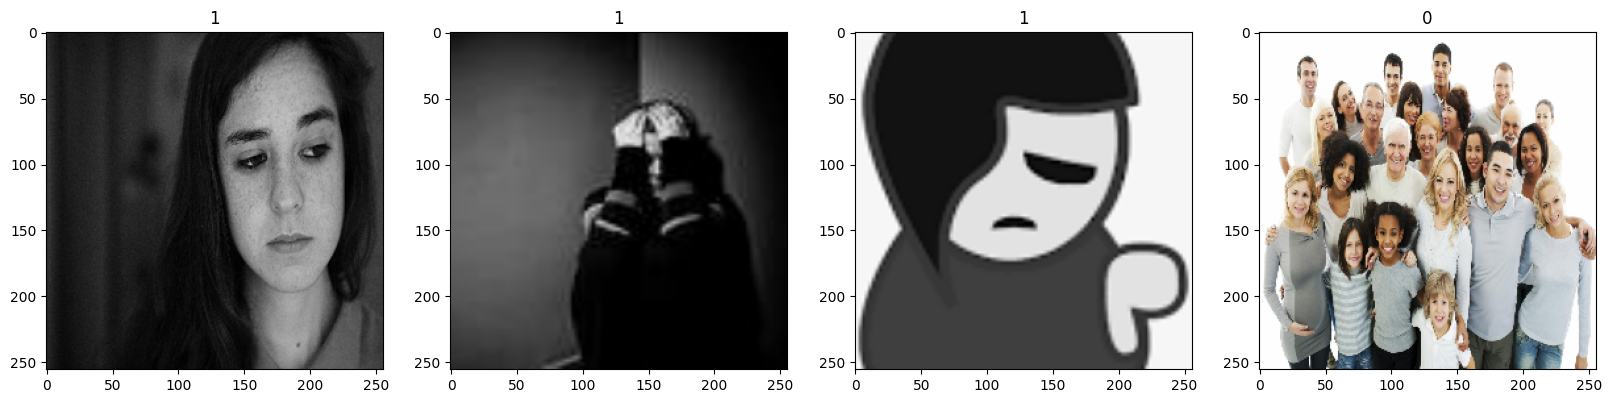

In [139]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [140]:
data = data.map(lambda x,y: (x/255, y))

In [141]:
batch=data.as_numpy_iterator().next()

In [142]:
batch[0].max()

np.float32(1.0)

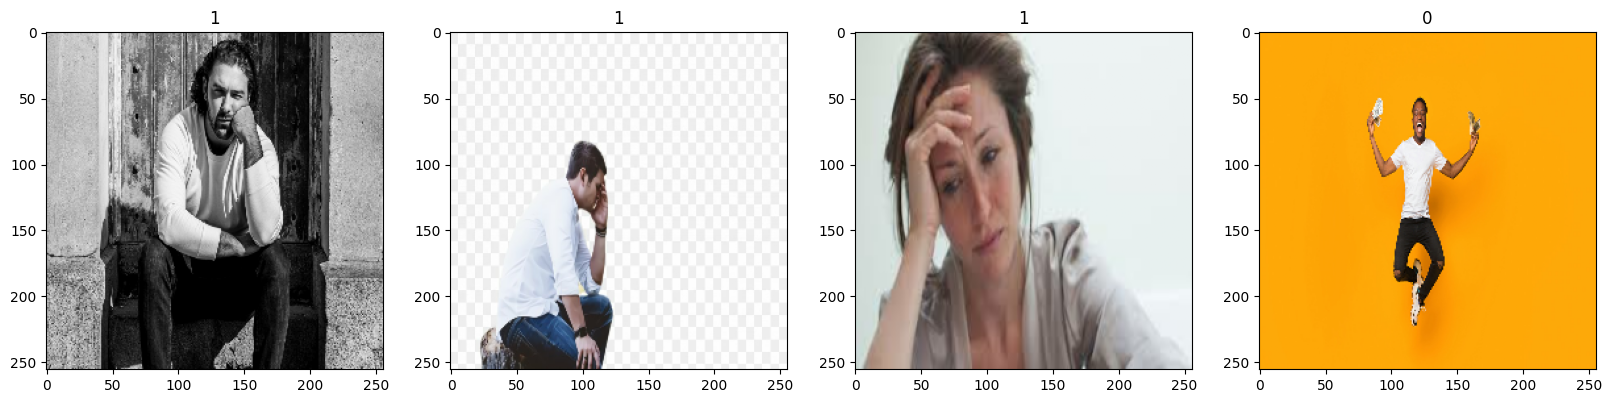

In [143]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [144]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [145]:
train_size

7

In [146]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [147]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [149]:
model = Sequential()

In [150]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [151]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [152]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [153]:
logdir='logs'

In [154]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [156]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9934 - loss: 0.0319 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9893 - loss: 0.0323 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9916 - loss: 0.0171 - val_accuracy: 0.9844 - val_loss: 0.0410
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9971 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0166
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9893 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9975 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9942 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 9/

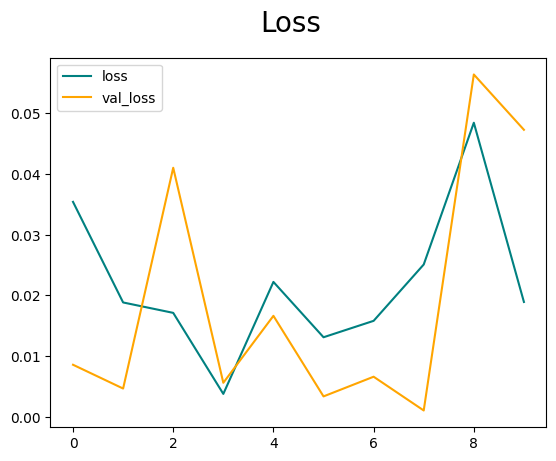

In [157]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

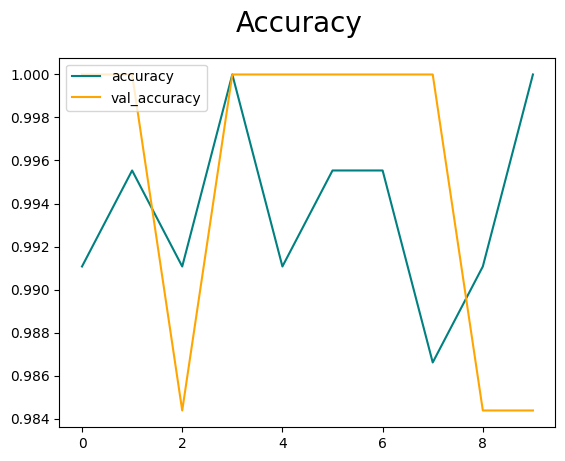

In [158]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [160]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [161]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [162]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


In [163]:
print(pre.result(), re.result(), acc.result())


tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


Saving b4.jpg to b4 (2).jpg


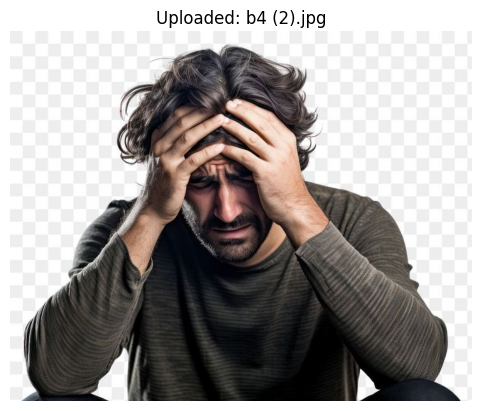

In [233]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

# Step 1: Upload an image file
uploaded = files.upload()

# Step 2: Get the uploaded filename
for file_name in uploaded.keys():
    img = cv2.imread(file_name)         # Read image using OpenCV (BGR format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

    # Step 3: Show image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Uploaded: {file_name}")
    plt.show()


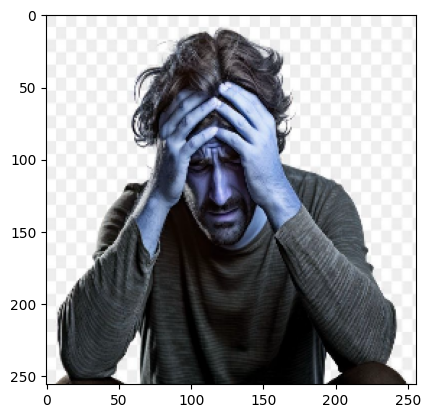

In [234]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [235]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


array([[0.991393]], dtype=float32)

In [236]:
if yhat > 0.5:
    print(f'Predicted class is sad')
else:
    print(f'Predicted class is Happy')

Predicted class is sad
